In [2]:
import pandas as pd
import numpy as np
import paths
import nibabel as nib
from scipy.stats import pearsonr
from nilearn import plotting

In [3]:
exp_folder = paths.sample_derivatives / "cust_kmeans_dist-correlation_ttype-percentage_tvalue-15_k-4_ninits-50_activation-pos_n-481"
cap_paths = sorted(exp_folder.glob("CAP_*_z.nii"))
n_caps = len(cap_paths)
print(f"Found {n_caps} CAP files.")

Found 4 CAP files.


In [4]:
vectorized_caps = []
for cap_idx, cap_path in enumerate(cap_paths):
    print(f"Processing {cap_idx+1}/{n_caps}: {cap_path.name}")
    cap = nib.load(cap_path)
    cap_data = cap.get_fdata()
    vectorized_caps.append(cap_data.flatten())


Processing 1/4: CAP_01_z.nii
Processing 2/4: CAP_02_z.nii
Processing 3/4: CAP_03_z.nii
Processing 4/4: CAP_04_z.nii


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# compute cap pairwise correlation matrix
corr_matrix = np.zeros((n_caps, n_caps))
for i in range(n_caps):
    for j in range(i,n_caps):
            corr_matrix[i, j] = pearsonr(vectorized_caps[i], vectorized_caps[j])[0]

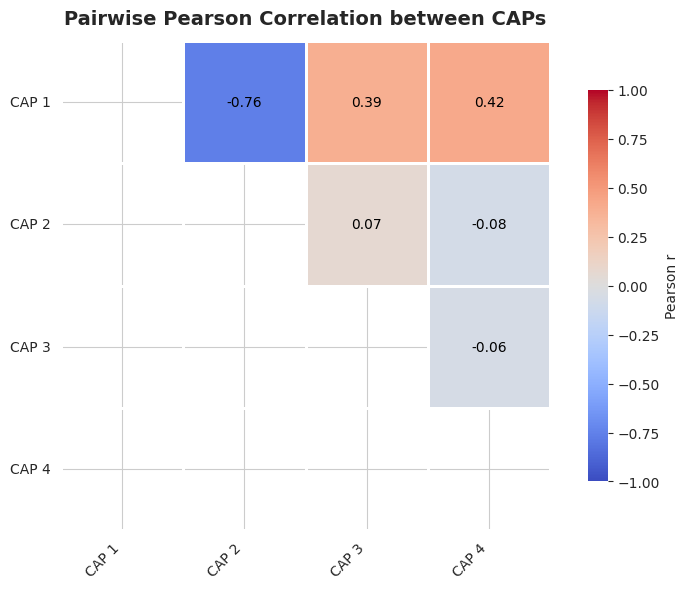

In [7]:
mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=0)
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.8,
    vmin=-1,
    vmax=1,
    cbar_kws={"shrink": 0.8, "label": "Pearson r"},
    xticklabels=[f"CAP {i+1}" for i in range(n_caps)],
    yticklabels=[f"CAP {i+1}" for i in range(n_caps)],
    annot_kws={"size": 10, "color": "black"},
)

plt.title("Pairwise Pearson Correlation between CAPs", fontsize=14, weight="bold", pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
sklearn_folder = paths.sample_derivatives / "sklearn_kmeans_dist-correlation_ttype-percentage_tvalue-15_k-4_ninits-50_activation-pos_n-481"
custkmeans_folder = paths.sample_derivatives / "cust_kmeans_dist-correlation_ttype-percentage_tvalue-15_k-4_ninits-50_activation-pos_n-481"

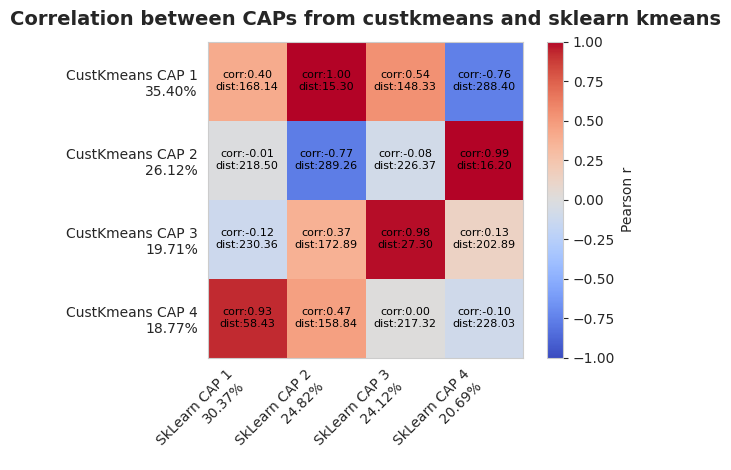

In [13]:
sklearn_cap_paths = sorted(sklearn_folder.glob("CAP_*_z.nii"))
custkmeans_cap_paths = sorted(custkmeans_folder.glob("CAP_*_z.nii"))
sklearn_cluster_sizes = pd.read_pickle(sklearn_folder / paths.cluster_sizes_df_name)
custkmeans_cluster_sizes = pd.read_pickle(custkmeans_folder / paths.cluster_sizes_df_name)


results = []
corrs = np.zeros((len(custkmeans_cap_paths), len(sklearn_cap_paths)))
l2dists = np.zeros((len(custkmeans_cap_paths), len(sklearn_cap_paths)))
for custkmeans_cap in custkmeans_cap_paths:
    term_cap_data = nib.load(custkmeans_cap).get_fdata().flatten()
    for sklearn_cap in sklearn_cap_paths:
        preterm_cap_data = nib.load(sklearn_cap).get_fdata().flatten()
        r, _ = pearsonr(term_cap_data, preterm_cap_data)
        l2dist = np.linalg.norm(term_cap_data - preterm_cap_data, ord=2)
        custkmeans_cap_id, sklearn_cap_id = custkmeans_cap_paths.index(custkmeans_cap), sklearn_cap_paths.index(sklearn_cap)
        corrs[custkmeans_cap_id, sklearn_cap_id] = r
        l2dists[custkmeans_cap_id, sklearn_cap_id] = l2dist
plt.imshow(corrs, cmap='coolwarm', vmin=-1, vmax=1)
for i in range(len(custkmeans_cap_paths)):
    for j in range(len(sklearn_cap_paths)):
        plt.text(j, i, f"corr:{corrs[i, j]:.2f}\ndist:{l2dists[i,j]:.2f}", ha='center', va='center', color='black', fontsize=8)

plt.colorbar(label='Pearson r')

plt.xticks(
    ticks=np.arange(len(sklearn_cap_paths)),
    labels=[
        f"SkLearn CAP {i+1}\n"
        f"{sklearn_cluster_sizes.iloc[i] / sklearn_cluster_sizes.sum() * 100:.2f}%"
        for i in range(len(sklearn_cap_paths))
    ],
    rotation=45,
    ha='right'
)
plt.yticks(
    ticks=np.arange(len(custkmeans_cap_paths)),
    labels=[
        f"CustKmeans CAP {i+1}\n"
        f"{custkmeans_cluster_sizes.iloc[i] / custkmeans_cluster_sizes.sum() * 100:.2f}%"
        for i in range(len(custkmeans_cap_paths))
    ],
    rotation=0
)

plt.title("Correlation between CAPs from custkmeans and sklearn kmeans", fontsize=14, weight="bold", pad=12)
plt.grid(False)
plt.tight_layout()
plt.show()


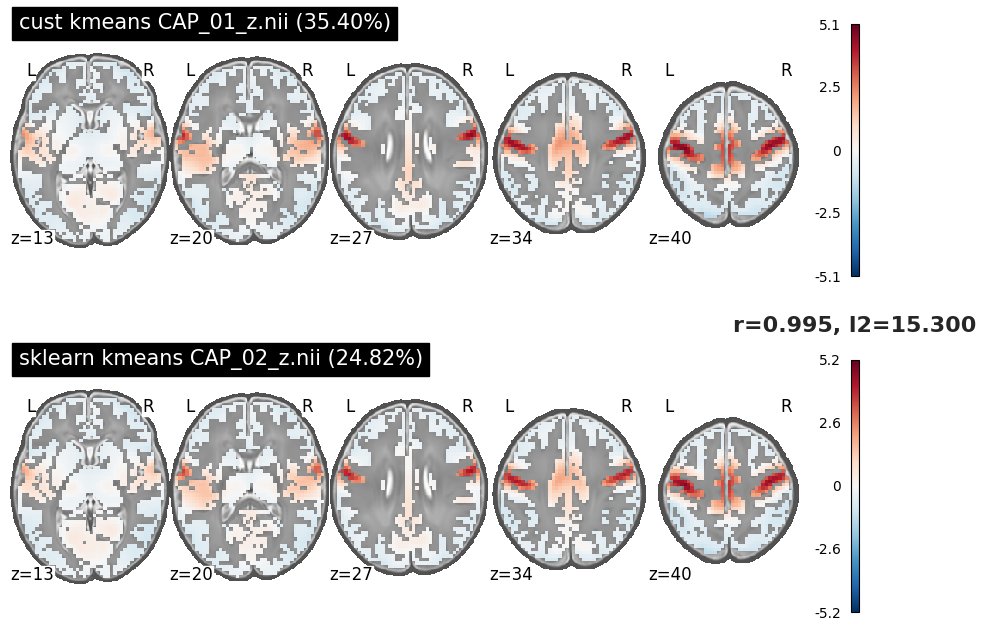

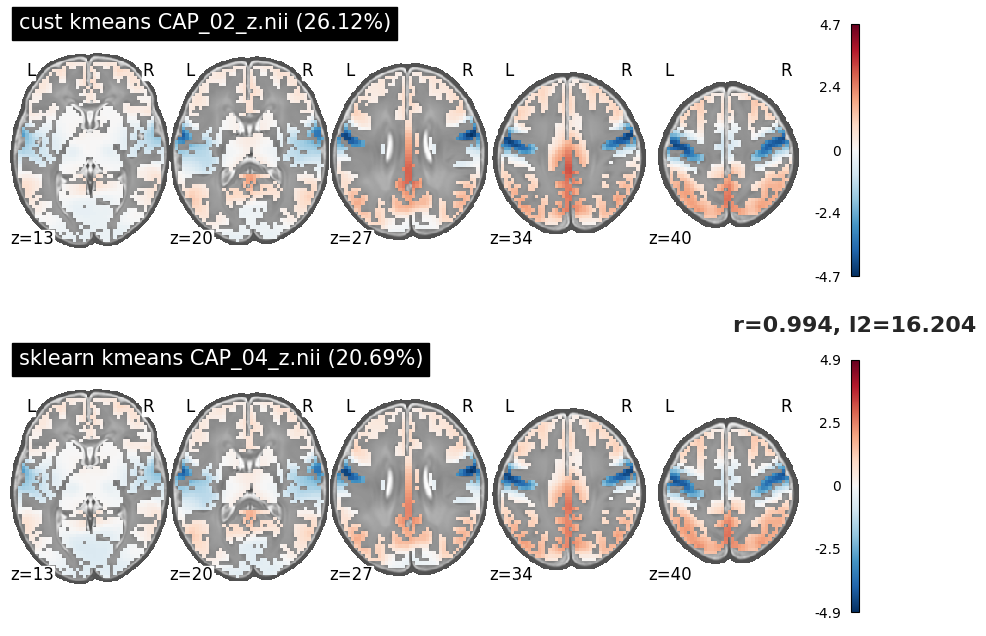

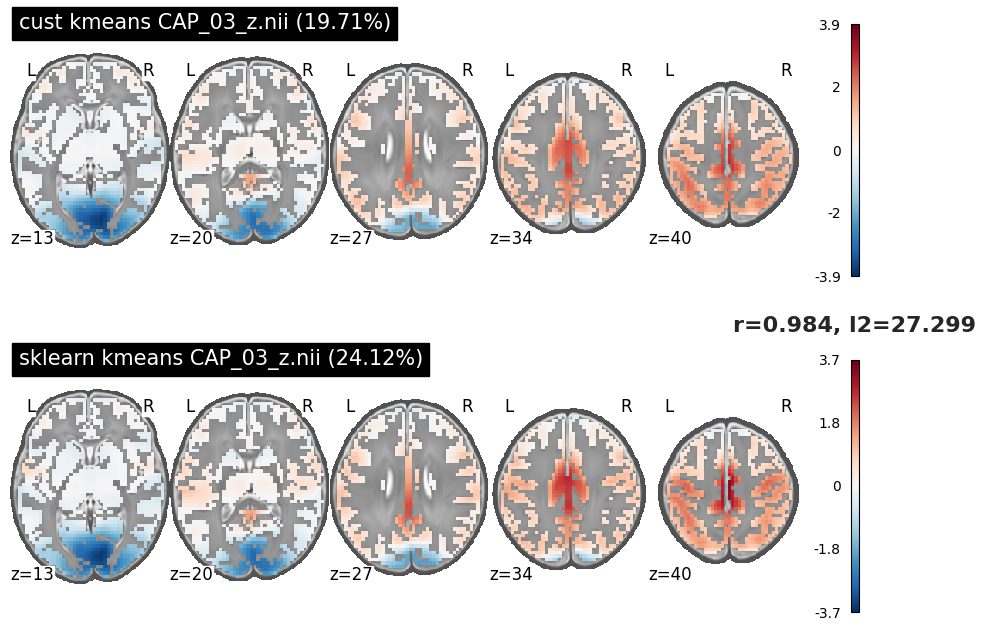

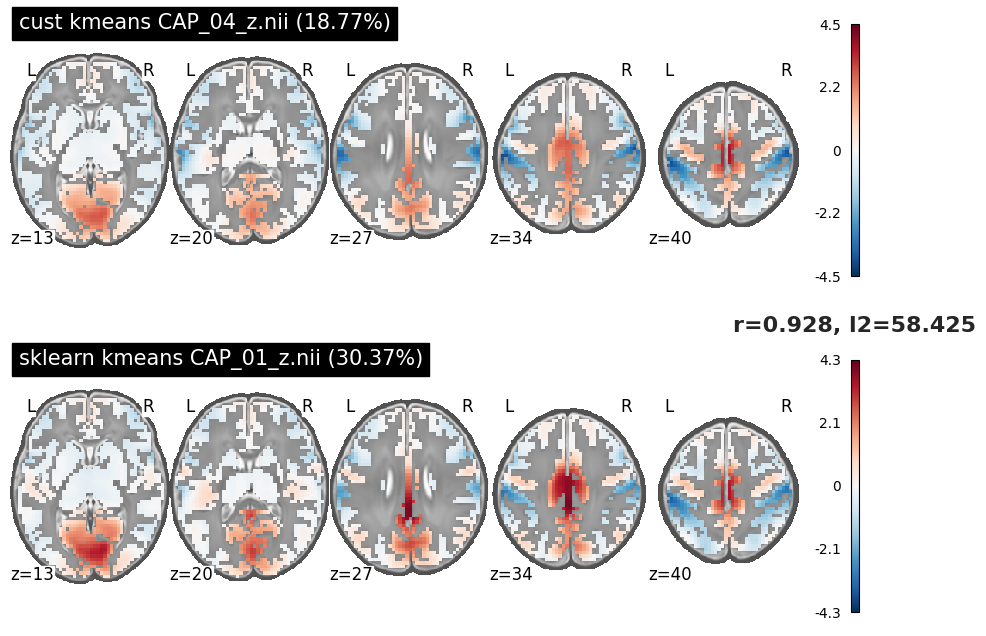

In [15]:
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib

for custkmeans_cap_id in range(corrs.shape[0]):

    sklearn_cap_id = np.argmax(corrs[custkmeans_cap_id, :])
    custkmeans_cap = custkmeans_cap_paths[custkmeans_cap_id]
    sklearn_cap = sklearn_cap_paths[sklearn_cap_id]
    correlation = corrs[custkmeans_cap_id, sklearn_cap_id]
    distance = l2dists[custkmeans_cap_id, sklearn_cap_id]

    sklearn_cap_prop = sklearn_cluster_sizes[sklearn_cap_id] / sklearn_cluster_sizes.sum() * 100
    custkmeans_cap_prop = custkmeans_cluster_sizes[custkmeans_cap_id] / custkmeans_cluster_sizes.sum() * 100

    term_cap_img = nib.load(custkmeans_cap)
    preterm_cap_img = nib.load(sklearn_cap)

    fig, axes = plt.subplots(2, 1, figsize=(11, 8))

    cut_coords = [13, 20 ,27, 34, 40]
    display1 = plotting.plot_stat_map(
        term_cap_img,
        title=f"cust kmeans {custkmeans_cap.name} ({custkmeans_cap_prop:.2f}%)",
        bg_img=paths.ext40Template,
        black_bg=False,
        display_mode="z",
        cut_coords=cut_coords,
        colorbar=True,
        axes=axes[0],
        figure=fig,
    )

    display2 = plotting.plot_stat_map(
        preterm_cap_img,
        title=f"sklearn kmeans {sklearn_cap.name} ({sklearn_cap_prop:.2f}%)",
        bg_img=paths.ext40Template,
        black_bg=False,
        display_mode="z",
        cut_coords=cut_coords,
        colorbar=True,
        axes=axes[1],
        figure=fig,
    )
    plt.title(f"r={correlation:.3f}, l2={distance:.3f}", fontsize=16, weight="bold", pad=20)
    plt.show()